In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();


import xgboost as xgb
import lightgbm as gbm

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report



In [2]:
train=pd.read_csv('Datasets/train.csv', encoding='iso-8859-1', on_bad_lines='skip')
test=pd.read_csv('Datasets/Test.csv', encoding='iso-8859-1', on_bad_lines='skip')

In [3]:
print(f"The shape of the train data: {train.shape}\nThe shape of the test data: {test.shape}")

The shape of the train data: (18506, 21)
The shape of the test data: (6169, 20)


In [4]:
train.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [5]:
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
total_female,18504.0,0.936230,1.215582,0.0,0.0,1.0,1.0,49.0
total_male,18500.0,0.998757,1.173177,0.0,1.0,1.0,1.0,58.0
night_mainland,18506.0,9.141576,14.127449,0.0,3.0,6.0,11.0,365.0
night_zanzibar,18506.0,2.493516,5.275156,0.0,0.0,0.0,4.0,240.0


In [7]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
total_female,6167.0,0.922491,1.173067,0.0,0.0,1.0,1.0,30.0
total_male,6168.0,1.017510,1.526274,0.0,1.0,1.0,1.0,90.0
night_mainland,6169.0,9.311720,16.366900,0.0,3.0,6.0,11.0,664.0
night_zanzibar,6169.0,2.585832,5.465058,0.0,0.0,0.0,4.0,174.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18506 entries, 0 to 18505
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Tour_ID                18506 non-null  object 
 1   country                18506 non-null  object 
 2   age_group              18506 non-null  object 
 3   travel_with            17431 non-null  object 
 4   total_female           18504 non-null  float64
 5   total_male             18500 non-null  float64
 6   purpose                18506 non-null  object 
 7   main_activity          18506 non-null  object 
 8   info_source            18506 non-null  object 
 9   tour_arrangement       18506 non-null  object 
 10  package_transport_int  18506 non-null  object 
 11  package_accomodation   18506 non-null  object 
 12  package_food           18506 non-null  object 
 13  package_transport_tz   18506 non-null  object 
 14  package_sightseeing    18506 non-null  object 
 15  pa

In [9]:
train.isna().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1075
total_female                2
total_male                  6
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category               0
dtype: int64

In [10]:
test.isna().sum()

Tour_ID                    0
country                    0
age_group                  0
travel_with              361
total_female               2
total_male                 1
purpose                    0
main_activity              0
info_source                0
tour_arrangement           0
package_transport_int      0
package_accomodation       0
package_food               0
package_transport_tz       0
package_sightseeing        0
package_guided_tour        0
package_insurance          0
night_mainland             0
night_zanzibar             0
first_trip_tz              0
dtype: int64

In [11]:
train['Tour_ID'].isin( test['Tour_ID']).sum()

0

### Merge the two datasets for easier exploration

In [45]:
df=pd.concat(objs=[train,test], axis=0)
df.shape

(24675, 21)

In [13]:
df.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
2,tour_id62vz7e71,UNITED STATES OF AMERICA,65+,With Spouse,1.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,No,6,6,Yes,Higher Cost
3,tour_idrc76tzix,RWANDA,25-44,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,No,No,No,No,No,No,3,0,No,Lower Cost
4,tour_idn723m0n9,UNITED STATES OF AMERICA,45-64,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,Yes,Yes,7,0,Yes,Higher Cost


In [14]:
df.tail()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
6164,tour_id2deyfjhq,ZIMBABWE,25-44,Alone,0.0,1.0,Business,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,2,0,No,NaN
6165,tour_idlenv2rio,DRC,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Hunting Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,60,0,Yes,NaN
6166,tour_id7wwqrs0p,CANADA,25-44,Alone,0.0,1.0,Leisure and Holidays,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,5,0,No,NaN
6167,tour_idx80vbw5a,CANADA,18-24,Alone,1.0,0.0,Visiting Friends and Relatives,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,21,0,No,NaN
6168,tour_id8fkkwytb,KENYA,45-64,NaN,0.0,1.0,Meetings and Conference,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,4,0,Yes,NaN


In [15]:
df.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with              1436
total_female                4
total_male                  7
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category            6169
dtype: int64

In [16]:
df.travel_with.value_counts()

Alone                           10118
With Spouse                      6435
With Other Friends/Relatives     4319
With Spouse and Children         1639
With Children                     728
Name: travel_with, dtype: int64

In [17]:
df.total_male.value_counts()[:5]

1.0    15772
0.0     5737
2.0     2036
3.0      658
4.0      193
5.0       95
Name: total_male, dtype: int64

In [18]:
df.total_female.value_counts()[:5]

1.0    12854
0.0     8226
2.0     2325
3.0      690
4.0      269
5.0      111
Name: total_female, dtype: int64

In [19]:
missing=df.isnull().sum()*100/len(df)
missing_df=pd.DataFrame({"columns":df.columns,
                         "percentage missing": missing})
missing_df.reset_index(drop=True, inplace=True)
missing_df

,columns,percentage missing
0,Tour_ID,0.000000
1,country,0.000000
2,age_group,0.000000
3,travel_with,5.819656
4,total_female,0.016211
5,total_male,0.028369
6,purpose,0.000000
7,main_activity,0.000000
8,info_source,0.000000
9,tour_arrangement,0.000000


- fill the missing values

In [20]:
from sklearn.impute import KNNImputer

imputer=KNNImputer(n_neighbors=5)
#numerical columns
df[['total_female', 'total_male']]=imputer.fit_transform(df[['total_female','total_male']])

#categorical column
df['travel_with'].fillna(df['travel_with'].mode()[0], inplace=True)

In [21]:
df.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with                 0
total_female                0
total_male                  0
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category            6169
dtype: int64

In [22]:
cat_cols=[col for col in train.select_dtypes('object').columns]
num_cols=[col for col in df.select_dtypes(['int64','float'])]

In [24]:
print(f"Category Columns: {cat_cols}\nNumerical Columns: {num_cols}")

Category Columns: ['Tour_ID', 'country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'first_trip_tz', 'cost_category']
Numerical Columns: ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']


## EDA

In [26]:
def eda(plot):
    for col in cat_cols:
        return col.value_counts()
        

- Visualize the target class

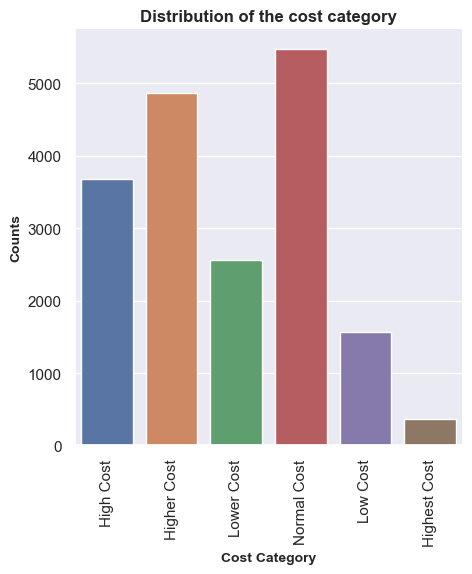

In [30]:
sns.axes_style(style="white")
ax=sns.catplot('cost_category', data=df, kind='count', legend=False)
plt.xlabel("Cost Category", size=10, weight="bold")
plt.ylabel("Counts", size=10, weight="bold")
plt.title("Distribution of the cost category", weight="bold")
ax.set_xticklabels( rotation=90)
plt.show();

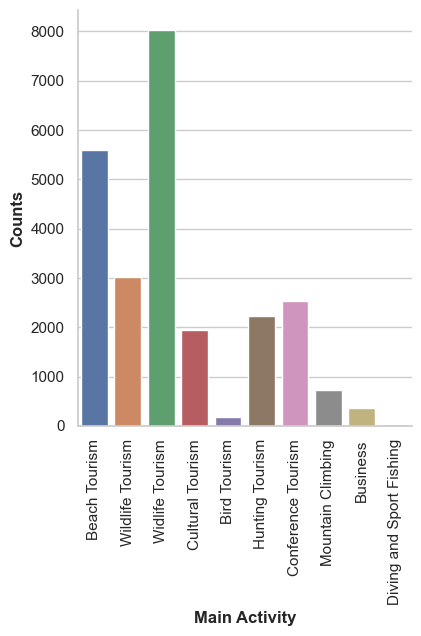

In [40]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot('main_activity', data=df, kind='count')
plt.xlabel("Main Activity", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.xticks(rotation=90)
plt.show();

In [46]:
df['main_activity']=df['main_activity'].replace('Widlife Tourism','Wildlife Tourism')

In [47]:
df.main_activity.value_counts()

Wildlife Tourism            11050
Beach Tourism                5604
Conference Tourism           2532
Hunting Tourism              2235
Cultural Tourism             1939
Mountain Climbing             727
Business                      370
Bird Tourism                  178
Diving and Sport Fishing       40
Name: main_activity, dtype: int64

In [49]:
data=df.groupby('main_activity').sum().reset_index()

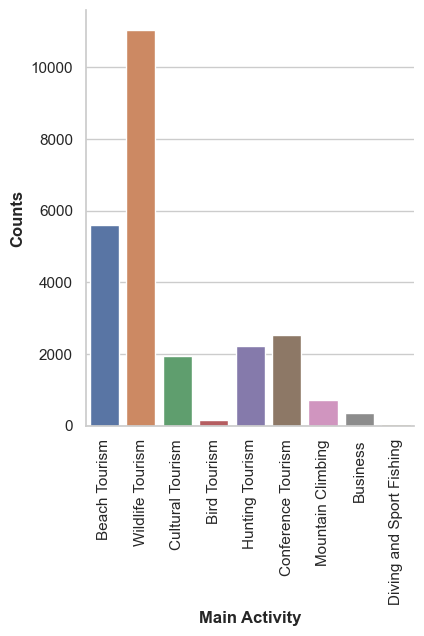

In [51]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot('main_activity', data=df, kind='count')
plt.xlabel("Main Activity", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.xticks(rotation=90)
plt.show()


### Building the models

In [ ]:
train=df(:,18506)
test=

In [54]:
train.shape, test.shape

((18506, 21), (6169, 20))

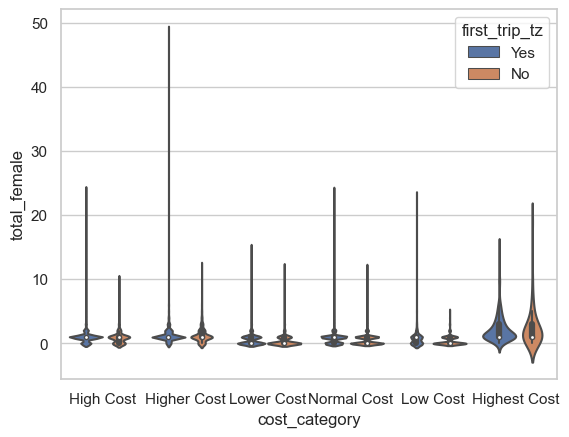

In [55]:
sns.violinplot(x='cost_category', y='total_female', hue='first_trip_tz', data=df);

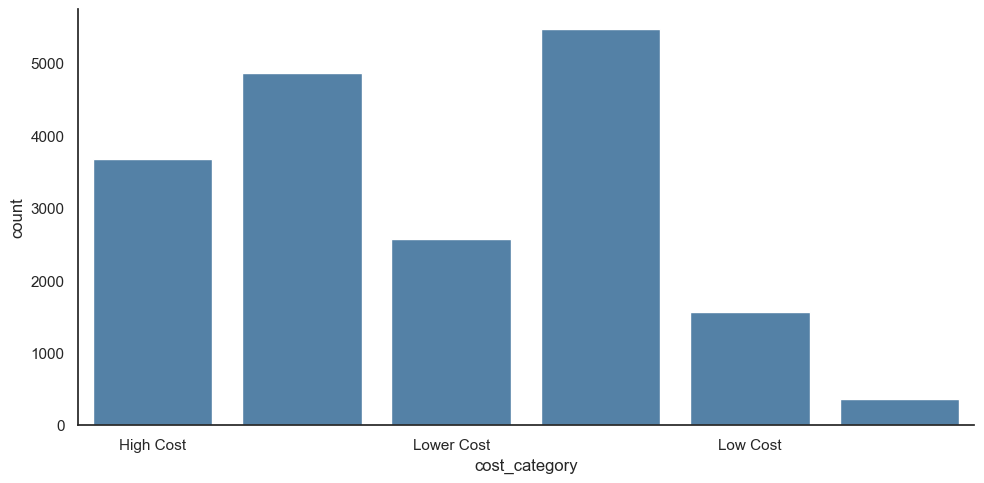

In [56]:
with sns.axes_style('white'):
    g=sns.catplot(x='cost_category', data=train,aspect=2,
                  kind='count',color='steelblue')
    g.set_xticklabels(step=2);

In [ ]:
y=train.cost_category.value_counts()

In [ ]:
sns.pairplot(train, hue='first_trip_tz', height=3.0);

In [15]:
data=train.groupby('cost_category')['country'].describe()

In [16]:
data

,count,unique,top,freq
cost_category,,,,
High Cost,3678,94,ITALY,733
Higher Cost,4865,90,UNITED STATES OF AMERICA,1320
Highest Cost,359,37,UNITED STATES OF AMERICA,79
Low Cost,1566,83,KENYA,175
Lower Cost,2567,86,UGANDA,367
Normal Cost,5471,119,UNITED KINGDOM,850


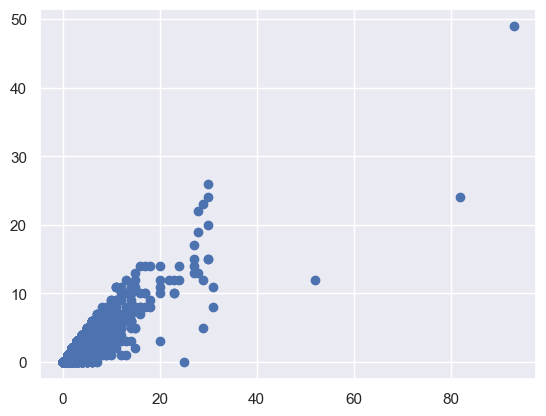

In [17]:
plt.scatter(train.total_people,train.total_female);

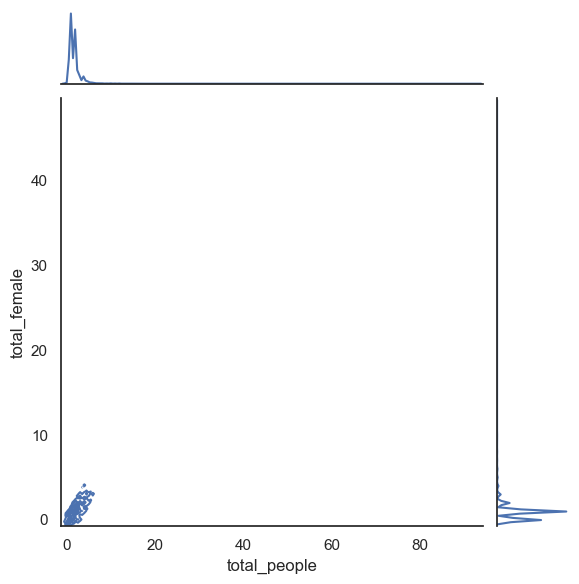

In [18]:
with sns.axes_style('white'):
    sns.jointplot(x=train.total_people, y=train.total_female, data=train, kind='kde');

In [19]:
test=pd.read_csv('Test.csv')

In [20]:
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [21]:
test.shape

(6169, 20)

In [22]:
train2=pd.read_csv('~/downloads/Train.csv')
train2.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [23]:
train2.shape

(4809, 23)

In [24]:
test2=pd.read_csv('~/downloads/Test.csv')

In [25]:
test2.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
0,tour_1,AUSTRALIA,45-64,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,10,3,Cash,Yes,Wildlife
1,tour_100,SOUTH AFRICA,25-44,Friends/Relatives,0.0,4.0,Business,Wildlife tourism,Tanzania Mission Abroad,Package Tour,...,No,No,No,No,No,13,0,Cash,No,"Wonderful Country, Landscape, Nature"
2,tour_1001,GERMANY,25-44,Friends/Relatives,3.0,0.0,Leisure and Holidays,Beach tourism,"Friends, relatives",Independent,...,No,No,No,No,No,7,14,Cash,No,No comments
3,tour_1006,CANADA,24-Jan,Friends/Relatives,2.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,No,0,4,Cash,Yes,Friendly People
4,tour_1009,UNITED KINGDOM,45-64,Friends/Relatives,2.0,2.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,No,No,10,0,Cash,Yes,Friendly People


In [26]:
test2.shape

(1601, 22)

In [27]:
train.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'total_people'],
      dtype='object')

In [28]:
train2.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')